# **Preprocessing of the LaRS Dataset**

The [LaRS (Lakes, Rivers and Seas) dataset](https://arxiv.org/pdf/2308.09618) is the largest and most diverse panoptic dataset for maritime obstacle detection. It consists of 4006 key frames with pixel-level annotations, divided into 2605 (65%) for training, 198 (5%) for validation, and 1203 (30%, not publicly available) for testing. Each image is annotated with a total of 11 classes, divided into 8 `thing` classes and 3 `stuff` classes, which makes the dataset suitable for both semantic and **panoptic segmentation**. However, since the original validation set is too small and the test annotations are not publicly available, the original training and validation sets were merged and then randomly split into 80% for training and 20% for validation using a **seed of 123**. This procedure ensures a similar proportion of `thing` class instances in both sets, thus balancing the dataset.

## **Imports**

In [ ]:
# Install the Hugging Face Datasets library
!pip install datasets -q

In [2]:
from datasets import Dataset, DatasetDict
from datasets import load_from_disk
from transformers.image_transforms import rgb_to_id
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import seaborn as sns
import colorcet as cc
from tqdm.auto import tqdm
from google.colab import drive
import json
import cv2
import os

In [3]:
# Mount Google Drive in Colab
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## **Parameters**

In [4]:
images_url = "https://box.vicos.si/lars/lars_v1.0.0_images.zip"
annotations_url = "https://box.vicos.si/lars/lars_v1.0.0_annotations.zip"
dataset_dir = "/content/LaRS"
zip_dataset_path = "/content/drive/MyDrive/Datasets/LaRS.zip"
val_size = 0.2
seed = 123

## **Download and Extract the Dataset**

The links to the LaRS images and annotations are available in its [official GitHub repository](https://lojzezust.github.io/lars-dataset/) after registration.

In [ ]:
!wget $images_url
!wget $annotations_url

--2025-03-30 12:49:09--  https://box.vicos.si/lars/lars_v1.0.0_images.zip
Resolving box.vicos.si (box.vicos.si)... 212.235.189.20
Connecting to box.vicos.si (box.vicos.si)|212.235.189.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1013227874 (966M) [application/zip]
Saving to: ‘lars_v1.0.0_images.zip’

lars_v1.0.0_images. 100%[===================>] 966.29M  25.5MB/s    in 42s     

2025-03-30 12:49:52 (23.1 MB/s) - ‘lars_v1.0.0_images.zip’ saved [1013227874/1013227874]

--2025-03-30 12:49:52--  https://box.vicos.si/lars/lars_v1.0.0_annotations.zip
Resolving box.vicos.si (box.vicos.si)... 212.235.189.20
Connecting to box.vicos.si (box.vicos.si)|212.235.189.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23443553 (22M) [application/zip]
Saving to: ‘lars_v1.0.0_annotations.zip’

lars_v1.0.0_annotat 100%[===================>]  22.36M  12.2MB/s    in 1.8s    

2025-03-30 12:49:55 (12.2 MB/s) - ‘lars_v1.0.0_annotations.zip’ saved [23

In [ ]:
!unzip -q {os.path.basename(images_url)}
!unzip -q {os.path.basename(annotations_url)}

## **Preprocess the Dataset**

In [ ]:
# Load the training and validation annotations
with open("/content/train/panoptic_annotations.json", "r") as file:
  train_annotations = json.load(file)

with open("/content/val/panoptic_annotations.json", "r") as file:
  val_annotations = json.load(file)


print(len(train_annotations["images"]), len(val_annotations["images"]))
print(val_annotations.keys())

2605 198
dict_keys(['info', 'images', 'annotations', 'categories', 'licenses'])


In [ ]:
# Print the number of images, annotations, and categories along with the first entry of each.
id = 0

print(len(val_annotations["images"]), val_annotations["images"][id])
print(len(val_annotations["annotations"]), val_annotations["annotations"][id])
print(len(val_annotations["categories"]), val_annotations["categories"][id])

198 {'id': 3995, 'width': 1280, 'height': 720, 'file_name': 'yt028_01_00030.jpg'}
198 {'image_id': 3995, 'file_name': 'yt028_01_00030.png', 'segments_info': [{'id': 1, 'category_id': 1, 'area': 161085, 'bbox': [0, 0, 1280, 413], 'iscrowd': 0}, {'id': 3, 'category_id': 3, 'area': 389388, 'bbox': [0, 360, 1280, 360], 'iscrowd': 0}, {'id': 5, 'category_id': 5, 'area': 306001, 'bbox': [0, 0, 1280, 315], 'iscrowd': 0}, {'category_id': 11, 'area': 4436, 'bbox': [550, 374, 121, 62], 'iscrowd': 0, 'id': 65547}, {'category_id': 11, 'area': 329, 'bbox': [701, 356, 36, 13], 'iscrowd': 0, 'id': 131083}, {'category_id': 11, 'area': 1040, 'bbox': [629, 351, 68, 18], 'iscrowd': 0, 'id': 196619}, {'category_id': 11, 'area': 29355, 'bbox': [0, 347, 351, 118], 'iscrowd': 0, 'id': 262155}, {'category_id': 11, 'area': 7965, 'bbox': [326, 338, 163, 59], 'iscrowd': 0, 'id': 327691}, {'category_id': 11, 'area': 10711, 'bbox': [1063, 388, 217, 59], 'iscrowd': 0, 'id': 393227}, {'category_id': 11, 'area': 4569

The LaRS annotations, provided in COCO format for panoptic segmentation, have class IDs that do not start at 0 and are not sequential, so this needs to be corrected.

In [ ]:
# Correct the class IDs and normalize their names
metadata = val_annotations["categories"]
raw_cls_to_cls = {dic["id"]: i for i, dic in enumerate(metadata)}

for dic in metadata:
  dic["name"] = dic["name"].lower()
  dic["id"] = raw_cls_to_cls[dic["id"]]

print(raw_cls_to_cls)

{1: 0, 3: 1, 5: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7, 16: 8, 17: 9, 19: 10}


In [ ]:
# Split the total annotations into training and validation
train_annotations, val_annotations = train_test_split(
    train_annotations["annotations"] + val_annotations["annotations"],
    test_size=val_size, random_state=seed
)

len(train_annotations), len(val_annotations)

(2242, 561)

For **panoptic segmentation** using Transformer models from [Hugging Face](https://huggingface.co/), it is necessary to prepare the annotations for the image processor of the chosen model. Each image must have a two-dimensional instance ID mask with the same height and width as the corresponding image. The values in this mask must be within the range $[1, N]$, where $N$ is the total number of instances in the image. The instance with a value of 0 is always ignored, as it is reserved for the null instance and therefore belongs to the null class (default value 255). Additionally, each image must be accompanied by a list of dictionaries that map each instance ID to its respective class ID.  

In this specific case, the maximum number of instances per image is limited to 255 due to computational constraints, as the plan is to fine-tune a model on the LaRS dataset for panoptic segmentation using Google Colab’s free GPU. This limitation also allows instance masks to be stored as `uint8` PIL images, reducing memory usage and enabling resizing with the PIL library without errors. Consequently, images and annotations with more than 255 instances are discarded. However, since only two records are affected, this exclusion does not significantly impact the dataset.  

Finally, once these components have been processed, two Hugging Face datasets one for training and one for validation are created. These datasets are then combined into a `DatasetDict` in Hugging Face and saved for future use.

In [ ]:
# Function to correct instance IDs and their corresponding class IDs
def correct_classes_and_ids(mask_ids, segments_info):
  new_mask_ids = np.zeros_like(mask_ids, dtype=np.uint8)

  for new_id, segment_info in enumerate(segments_info, 1):
    new_mask_ids[mask_ids == segment_info["id"]] = new_id
    segment_info["id"] = new_id
    segment_info["category_id"] = raw_cls_to_cls[segment_info["category_id"]]

  return new_mask_ids, segments_info


# Function to convert annotations into a dictionary containing images, instance masks, and instance-to-class ID mappings
def create_data(annotations):
  images, masks, list_segments_info = [], [], []

  for annotation in tqdm(annotations):
    filename = annotation["file_name"]

    if len(annotation["segments_info"]) > 255:
      print(f"Ignoring file {filename} because it has more than 255 instances")
      continue
    
    # Extract the image and mask paths
    split = "train" if os.path.exists(os.path.join("train", "images", filename.replace(".png", ".jpg"))) else "val"
    image_path = os.path.join(split, "images", filename.replace(".png", ".jpg"))
    mask_path = os.path.join(split, "panoptic_masks", filename)
    
    # Load the image and its corresponding mask
    image = Image.open(image_path)
    mask = np.array(Image.open(mask_path))
    
    # Convert the COCO RGB mask to instance values
    mask = rgb_to_id(mask)

    # Correct instance and class IDs
    mask, segments_info = correct_classes_and_ids(mask, annotation["segments_info"])
    mask = Image.fromarray(mask)

    images.append(image)
    masks.append(mask)
    list_segments_info.append(segments_info)

  return {
      "image": images,
      "mask": masks,
      "segments_info": list_segments_info
  }


# Function to process and store images and annotations in a Hugging Face 'DatasetDict'
def save_data(train_annotations, val_annotations, path_save):
  train_dataset = Dataset.from_dict(create_data(train_annotations))
  val_dataset = Dataset.from_dict(create_data(val_annotations))

  dataset = DatasetDict({
      "train": train_dataset,
      "val": val_dataset
  })
  
  # Save the complete dataset
  os.makedirs(path_save, exist_ok=True)
  dataset.save_to_disk(path_save)
  
  # Save the dataset metadata
  with open(os.path.join(path_save, "metadata.json"), "w") as file:
    json.dump(metadata, file)

In [ ]:
save_data(train_annotations, val_annotations, dataset_dir)

  0%|          | 0/2242 [00:00<?, ?it/s]

Ignoring file yt087_01_00039.png because it has more than 255 instances
Ignoring file yt087_00_00129.png because it has more than 255 instances


  0%|          | 0/561 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/2240 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/561 [00:00<?, ? examples/s]

In [ ]:
# Compress the dataset into a zip file and save it
!zip -r $zip_dataset_path {os.path.basename(dataset_dir)} -q

## **Exploratory Data Analysis (EDA)**

In [ ]:
# Load the processed dataset and its metadata
dataset = load_from_disk(dataset_dir)

with open(os.path.join(dataset_dir, "metadata.json"), "r") as file:
  metadata = json.load(file)

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'mask', 'segments_info'],
        num_rows: 2240
    })
    val: Dataset({
        features: ['image', 'mask', 'segments_info'],
        num_rows: 561
    })
})

In [ ]:
# Map class IDs to labels and colors from metadata 
id2label = {dic["id"]: dic["name"] for dic in metadata}
id2color = {dic["id"]: tuple(dic["color"]) for dic in metadata}

# Extract IDs of "thing" classes and unique colors for "stuff" classes 
things = [dic["id"] for dic in metadata if dic["isthing"]]
stuff_colors = {tuple(dic["color"]) for dic in metadata if not dic["isthing"]}

# Generate a distinct color palette using Glasbey colormap  
palette = list({
    (int(r * 255), int(g * 255), int(b * 255))
    for r, g, b in sns.color_palette(cc.glasbey)
})

In [ ]:
# Function to extract instance counts for "thing" classes
def count_instances(annotations):
  dic_classes = {v: 0 for k, v in id2label.items() if k in things}

  for annotation in tqdm(annotations):
    for segment_info in annotation["segments_info"]:
      cls = segment_info["category_id"]

      if cls in things:
        dic_classes[id2label[cls]] += 1

  df = pd.DataFrame(list(dic_classes.items()), columns=["Class", "Count"])
  return df

In [ ]:
num_train_instances = count_instances(train_annotations)
num_val_instances = count_instances(val_annotations)

  0%|          | 0/2242 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

In [ ]:
num_val_instances.Count / (num_train_instances.Count + num_val_instances.Count)

,Count
0,0.197498
1,0.215481
2,0.241935
3,0.197633
4,0.154667
5,0.212276
6,0.192308
7,0.181185


It can be observed that the proportion of `thing` class instances is approximately the same in both the training and validation datasets.

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.0 MB/s eta 0:00:00


In [ ]:
# Function to plot a bar chart of "thing" class instance counts
def plot_counts(num_instances, split="training", renderer=None):
  num_instances = num_instances.sort_values(by="Count")
  fig = px.bar(
      num_instances, x="Count", y="Class",
      text="Count", color="Count",
      color_continuous_scale=[(0, "#D80000"), (0.5, "lightblue"), (1, "#003299")]
  )

  total_count = num_instances.Count.sum()
  fig.update_layout(
      title=dict(
          text=f"Counts of Thing Classes in the {split.capitalize()} Set (Total: {total_count})",
          font=dict(size=15, weight="bold"),
          x=0.5
      ),
      xaxis_title=dict(text="Frequency", font=dict(size=12, weight="bold")),
      yaxis_title=dict(text="Class", font=dict(size=12, weight="bold")),
      height=500,
      width=1000
  )
  fig.show(renderer=renderer)

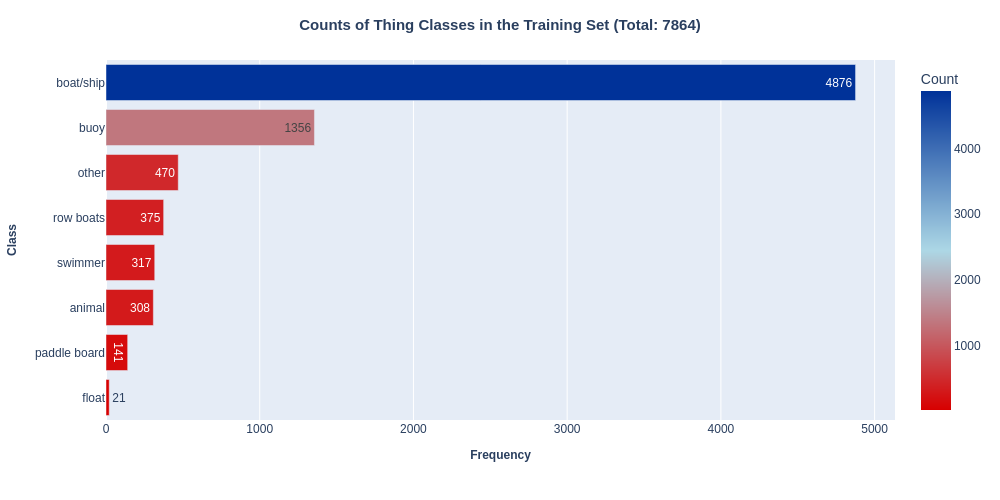

In [ ]:
plot_counts(num_train_instances)
plot_counts(num_train_instances, renderer="png")

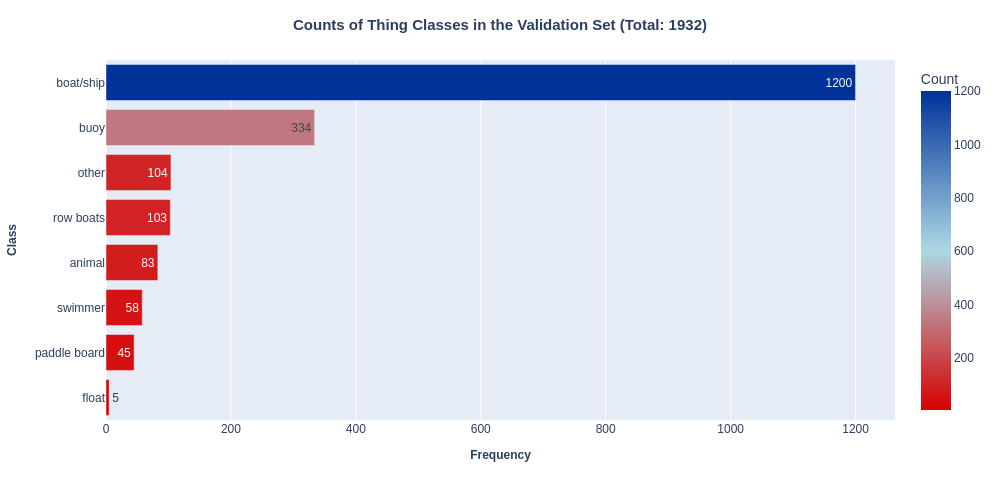

In [ ]:
plot_counts(num_val_instances, split="validation")
plot_counts(num_val_instances, split="validation", renderer="png")

A class imbalance is observed among the `thing` categories, with `float` being the least frequent class, having only 26 instances. If the original training and validation datasets had not been merged before being randomly split into 80% and 20%, respectively, this imbalance would have been even worse. For instance, the `float` class originally had only 3 instances in the validation set, making it unrepresentative for assessing the performance of a panoptic segmentation model.

## **Visualization Example**

In this case, instances of `stuff` classes, which are at most one per panoptic mask, will always retain their original color assigned in the LaRS dataset when visualized. On the other hand, for `thing` classes, only the first instance of each class will keep its original LaRS color, while the remaining instances in the panoptic mask will be assigned unique colors from the previously selected palette. Additionally, bounding boxes will be drawn for `thing` class instances. This ensures that no instance shares the same color with another, whether from its own class or a different class, within a given panoptic mask.

In [ ]:
# Function to compute the bounding box coordinates of a binary mask
def get_bbox(binary_mask):
  rows = np.any(binary_mask, axis=1)
  cols = np.any(binary_mask, axis=0)
  ymin, ymax = np.where(rows)[0][[0, -1]]
  xmin, xmax = np.where(cols)[0][[0, -1]]

  return xmin, ymin, xmax, ymax


# Function to compute the centroid of a binary mask using the median
def get_center(binary_mask):
  y_indices, x_indices = np.where(binary_mask == 1)
  x = np.median(x_indices)
  y = np.median(y_indices)

  return x, y

In [ ]:
# Function to display an image with a panoptic segmentation mask
def plot_image_masks(dataset, random=True, blended=False, alpha=0.5):
  idx = np.random.randint(0, len(dataset)) if random else 0
  fig, ax = plt.subplots(2, 1, figsize=(9.6, 9.6))
  
  # Extract the image and its instance mask
  sample = dataset[idx]
  image = np.array(sample["image"])
  mask = np.array(sample["mask"])
  
  # Initialize the RGB mask and the set of used colors
  mask_rgb = np.zeros(mask.shape[:2] + (3,), dtype=np.uint8)
  used_colors = {(0, 0, 0)} | stuff_colors
  i = 0

  for segment_info in sample["segments_info"]:
    cls = segment_info["category_id"]
    color = id2color[cls]
    name = id2label[cls]
    
    # Iterate through the color palette until an unused color is found
    if (cls in things) and (color in used_colors):
      while (color := palette[i]) in used_colors:
        i += 1
    used_colors.add(color) 
    
    # Fill the RGB mask with the color corresponding to the instance ID
    mask_rgb[mask == segment_info["id"]] = list(color)

    # Compute the binary mask for the corresponding instance ID
    mask_id = (mask == segment_info["id"]).astype(np.uint8)
    
    # If the class ID belongs to "things," draw its bounding box and class name
    if cls in things:
      xmin, ymin, xmax, ymax = get_bbox(mask_id)
      color = tuple(np.array(color) / 255)
      rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=color, facecolor="none")

      # Adjust text positioning to prevent overlap with image boundaries
      height, width = image.shape[:2]
      x, ha = (xmin, "left") if xmax < (0.85 * width) else (xmax, "right")
      y, va = (ymin, "bottom") if ymin > (0.15 * height) else (ymax, "top")

      ax[1].add_patch(rect)
      ax[1].text(
          x, y, name, fontsize=7,
          color="black", fontweight="bold", ha=ha, va=va,
          bbox={"boxstyle": "square,pad=0", "facecolor": color, "edgecolor": color, "alpha": 0.7}
      )
    
    # If the class ID belongs to "stuff," display only the class name
    else:
      x, y = get_center(mask_id)
      ax[1].text(
          x, y, name, fontsize=8,
          color="white", fontweight="bold", ha="center", va="center",
          bbox={"boxstyle": "square,pad=0", "facecolor": "black", "alpha": 0.7}
      )
  
  # Merge the RGB mask with the image if enabled
  if blended:
    mask_rgb = cv2.addWeighted(image / 255, 1 - alpha, mask_rgb / 255, alpha, 0)

  ax[0].imshow(image)
  ax[1].imshow(mask_rgb)

  ax[0].axis("off")
  ax[1].axis("off")

  plt.tight_layout()
  plt.show()

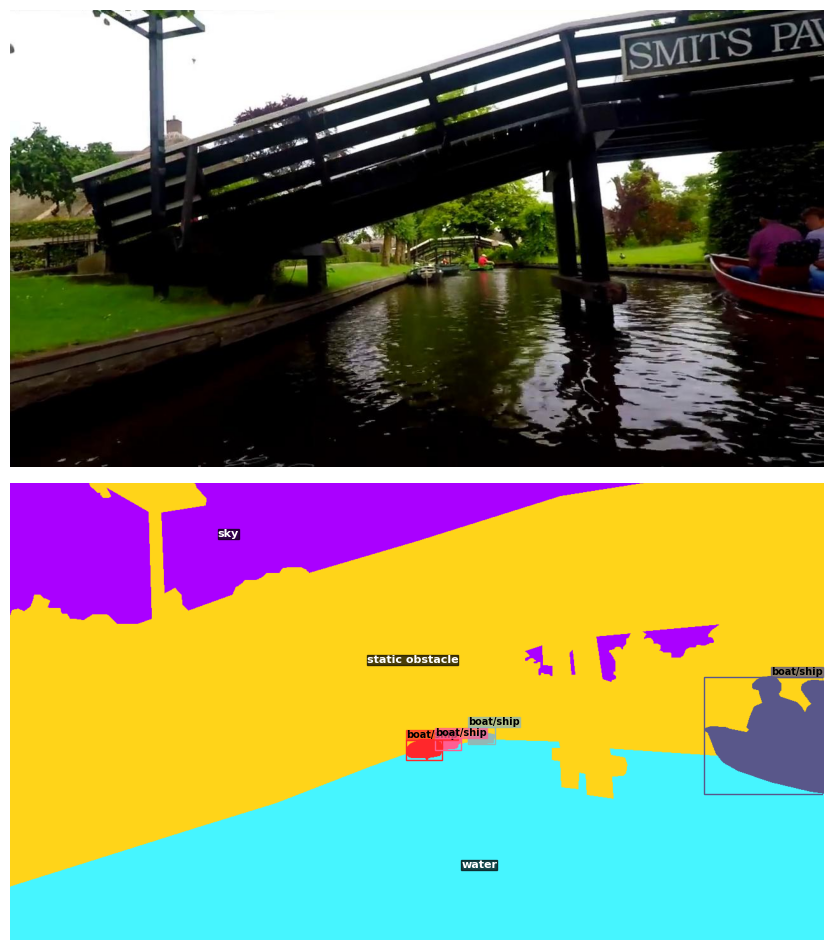

In [ ]:
plot_image_masks(dataset["train"])

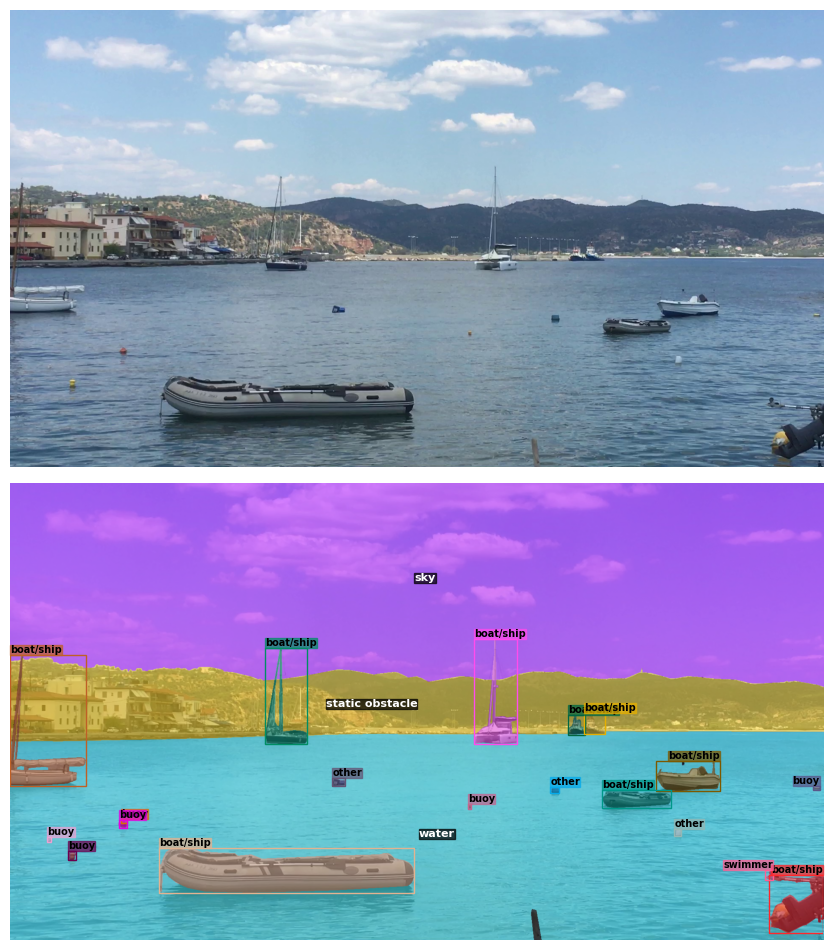

In [115]:
plot_image_masks(dataset["train"], blended=True)